# Lab 5 - Joining Uber Pick-Ups, Stations, and Boroughs

In [Lecture 3.4](./3_4_joining_large_and_small_files.ipynb), we introduced using a Python `dict` to join a large and small table.  In this lab, we will practice this technique on the uber data set.

**Note:** Make sure that you download and unzip the file `Uber-Jan-Feb-FOIL.csv` before proceeding.

In [82]:
import pandas as pd
from dfply import *

In [114]:
c_size = 500000
trips = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv", chunksize=c_size)
first_chunk = next(trips)

In [115]:
first_chunk.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


## <font color="red"> Problem 1 - Creating 2 Location `dict`</font>

Read the file `taxi-zone-lookup.csv` and inspect the columns. What 2 pieces of information will this file allow us to add to the `uber-raw-data-janjune-15.csv`?  Make a `dict` for each of these variables.

We can add the Borough and the Zone

In [116]:
lookup = pd.read_csv("./data/uber/uber-trip-data/taxi-zone-lookup.csv")
lookup.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [117]:
borough = {iD:name for iD, name in zip(lookup.LocationID, lookup.Borough)}
borough

{1: 'EWR',
 2: 'Queens',
 3: 'Bronx',
 4: 'Manhattan',
 5: 'Staten Island',
 6: 'Staten Island',
 7: 'Queens',
 8: 'Queens',
 9: 'Queens',
 10: 'Queens',
 11: 'Brooklyn',
 12: 'Manhattan',
 13: 'Manhattan',
 14: 'Brooklyn',
 15: 'Queens',
 16: 'Queens',
 17: 'Brooklyn',
 18: 'Bronx',
 19: 'Queens',
 20: 'Bronx',
 21: 'Brooklyn',
 22: 'Brooklyn',
 23: 'Staten Island',
 24: 'Manhattan',
 25: 'Brooklyn',
 26: 'Brooklyn',
 27: 'Queens',
 28: 'Queens',
 29: 'Brooklyn',
 30: 'Queens',
 31: 'Bronx',
 32: 'Bronx',
 33: 'Brooklyn',
 34: 'Brooklyn',
 35: 'Brooklyn',
 36: 'Brooklyn',
 37: 'Brooklyn',
 38: 'Queens',
 39: 'Brooklyn',
 40: 'Brooklyn',
 41: 'Manhattan',
 42: 'Manhattan',
 43: 'Manhattan',
 44: 'Staten Island',
 45: 'Manhattan',
 46: 'Bronx',
 47: 'Bronx',
 48: 'Manhattan',
 49: 'Brooklyn',
 50: 'Manhattan',
 51: 'Bronx',
 52: 'Brooklyn',
 53: 'Queens',
 54: 'Brooklyn',
 55: 'Brooklyn',
 56: 'Queens',
 57: 'Queens',
 58: 'Bronx',
 59: 'Bronx',
 60: 'Bronx',
 61: 'Brooklyn',
 62: 'Broo

In [118]:
zone = {iD:name for iD, name in zip(lookup.LocationID, lookup.Zone)}
zone

{1: 'Newark Airport',
 2: 'Jamaica Bay',
 3: 'Allerton/Pelham Gardens',
 4: 'Alphabet City',
 5: 'Arden Heights',
 6: 'Arrochar/Fort Wadsworth',
 7: 'Astoria',
 8: 'Astoria Park',
 9: 'Auburndale',
 10: 'Baisley Park',
 11: 'Bath Beach',
 12: 'Battery Park',
 13: 'Battery Park City',
 14: 'Bay Ridge',
 15: 'Bay Terrace/Fort Totten',
 16: 'Bayside',
 17: 'Bedford',
 18: 'Bedford Park',
 19: 'Bellerose',
 20: 'Belmont',
 21: 'Bensonhurst East',
 22: 'Bensonhurst West',
 23: 'Bloomfield/Emerson Hill',
 24: 'Bloomingdale',
 25: 'Boerum Hill',
 26: 'Borough Park',
 27: 'Breezy Point/Fort Tilden/Riis Beach',
 28: 'Briarwood/Jamaica Hills',
 29: 'Brighton Beach',
 30: 'Broad Channel',
 31: 'Bronx Park',
 32: 'Bronxdale',
 33: 'Brooklyn Heights',
 34: 'Brooklyn Navy Yard',
 35: 'Brownsville',
 36: 'Bushwick North',
 37: 'Bushwick South',
 38: 'Cambria Heights',
 39: 'Canarsie',
 40: 'Carroll Gardens',
 41: 'Central Harlem',
 42: 'Central Harlem North',
 43: 'Central Park',
 44: 'Charleston/Tot

## <font color="red"> Problem 2 - Dispatch Translation</font>

The following table was taken from the FiveThirtyEight github page and contains the names of each Uber dispatch station.  Create a translation `dict` for these data.

Base Code | Base Name
---|---------
B02512 | Unter
B02598 | Hinter
B02617 | Weiter
B02682 | Schmecken
B02764 | Danach-NY
B02765 | Grun
B02835 | Dreist
B02836 | Drinnen

In [119]:
base = {code: name for code, name in zip(['B02512','B02598', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02836'],
                                        ['Unter','Hinter', 'Weiter', 'Schmecken', 'Danach-NY', 'Grun', 'Dreist', 'Drinnen'])}
base

{'B02512': 'Unter',
 'B02598': 'Hinter',
 'B02617': 'Weiter',
 'B02682': 'Schmecken',
 'B02764': 'Danach-NY',
 'B02765': 'Grun',
 'B02835': 'Dreist',
 'B02836': 'Drinnen'}

## <font color="red"> Problem 3 - Prototyping a Helper Function</font>

Use the first chunk to prototype a helper function that

1. Add 3 new columns, one for each key/translation.
2. Drop each of the associated keys.
3. Convert the `pickup_date` to a datetime column.
4. Add various datepart columns

This function should use appropriate `dfply` functions and a pipe.

In [120]:
first_chunk.Dispatching_base_num.map(base).head()

0    Weiter
1    Weiter
2    Weiter
3    Weiter
4    Weiter
Name: Dispatching_base_num, dtype: object

In [94]:
from more_dfply import recode
first_chunk = (first_chunk >> mutate(base = recode(X.Dispatching_base_num, base), 
                                      borough = recode(X.locationID, borough),
                                      zone = recode(X.locationID, zone)))
first_chunk.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,base,borough,zone
0,B02617,2015-05-17 09:47:00,B02617,141,Weiter,Manhattan,Lenox Hill West
1,B02617,2015-05-17 09:47:00,B02617,65,Weiter,Brooklyn,Downtown Brooklyn/MetroTech
2,B02617,2015-05-17 09:47:00,B02617,100,Weiter,Manhattan,Garment District
3,B02617,2015-05-17 09:47:00,B02774,80,Weiter,Brooklyn,East Williamsburg
4,B02617,2015-05-17 09:47:00,B02617,90,Weiter,Manhattan,Flatiron


In [121]:
def zipDict(keys, values):
    return {key:val for key, val in zip(keys, values)}
borough = zipDict(lookup.LocationID, lookup.Borough)
borough

{1: 'EWR',
 2: 'Queens',
 3: 'Bronx',
 4: 'Manhattan',
 5: 'Staten Island',
 6: 'Staten Island',
 7: 'Queens',
 8: 'Queens',
 9: 'Queens',
 10: 'Queens',
 11: 'Brooklyn',
 12: 'Manhattan',
 13: 'Manhattan',
 14: 'Brooklyn',
 15: 'Queens',
 16: 'Queens',
 17: 'Brooklyn',
 18: 'Bronx',
 19: 'Queens',
 20: 'Bronx',
 21: 'Brooklyn',
 22: 'Brooklyn',
 23: 'Staten Island',
 24: 'Manhattan',
 25: 'Brooklyn',
 26: 'Brooklyn',
 27: 'Queens',
 28: 'Queens',
 29: 'Brooklyn',
 30: 'Queens',
 31: 'Bronx',
 32: 'Bronx',
 33: 'Brooklyn',
 34: 'Brooklyn',
 35: 'Brooklyn',
 36: 'Brooklyn',
 37: 'Brooklyn',
 38: 'Queens',
 39: 'Brooklyn',
 40: 'Brooklyn',
 41: 'Manhattan',
 42: 'Manhattan',
 43: 'Manhattan',
 44: 'Staten Island',
 45: 'Manhattan',
 46: 'Bronx',
 47: 'Bronx',
 48: 'Manhattan',
 49: 'Brooklyn',
 50: 'Manhattan',
 51: 'Bronx',
 52: 'Brooklyn',
 53: 'Queens',
 54: 'Brooklyn',
 55: 'Brooklyn',
 56: 'Queens',
 57: 'Queens',
 58: 'Bronx',
 59: 'Bronx',
 60: 'Bronx',
 61: 'Brooklyn',
 62: 'Broo

In [122]:
zone = zipDict(lookup.LocationID, lookup.Zone)
zone

{1: 'Newark Airport',
 2: 'Jamaica Bay',
 3: 'Allerton/Pelham Gardens',
 4: 'Alphabet City',
 5: 'Arden Heights',
 6: 'Arrochar/Fort Wadsworth',
 7: 'Astoria',
 8: 'Astoria Park',
 9: 'Auburndale',
 10: 'Baisley Park',
 11: 'Bath Beach',
 12: 'Battery Park',
 13: 'Battery Park City',
 14: 'Bay Ridge',
 15: 'Bay Terrace/Fort Totten',
 16: 'Bayside',
 17: 'Bedford',
 18: 'Bedford Park',
 19: 'Bellerose',
 20: 'Belmont',
 21: 'Bensonhurst East',
 22: 'Bensonhurst West',
 23: 'Bloomfield/Emerson Hill',
 24: 'Bloomingdale',
 25: 'Boerum Hill',
 26: 'Borough Park',
 27: 'Breezy Point/Fort Tilden/Riis Beach',
 28: 'Briarwood/Jamaica Hills',
 29: 'Brighton Beach',
 30: 'Broad Channel',
 31: 'Bronx Park',
 32: 'Bronxdale',
 33: 'Brooklyn Heights',
 34: 'Brooklyn Navy Yard',
 35: 'Brownsville',
 36: 'Bushwick North',
 37: 'Bushwick South',
 38: 'Cambria Heights',
 39: 'Canarsie',
 40: 'Carroll Gardens',
 41: 'Central Harlem',
 42: 'Central Harlem North',
 43: 'Central Park',
 44: 'Charleston/Tot

In [98]:
first_chunk.Pickup_date = pd.to_datetime(first_chunk.Pickup_date)
first_chunk.Pickup_date.head()

0   2015-05-17 09:47:00
1   2015-05-17 09:47:00
2   2015-05-17 09:47:00
3   2015-05-17 09:47:00
4   2015-05-17 09:47:00
Name: Pickup_date, dtype: datetime64[ns]

In [99]:
first_chunk.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
base                            object
borough                         object
zone                            object
dtype: object

In [123]:
first_chunk.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [165]:
from more_dfply import to_datetime 
add_dateparts =  pipeable(lambda df: (df >> mutate(base = recode(X.Dispatching_base_num, base), 
                                     affilBase = recode(X.Affiliated_base_num, base),
                                     borough = recode(X.locationID, borough),
                                     zone = recode(X.locationID, zone),
                                     date = to_datetime(X.Pickup_date)) >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                         weekofyear = X.date.dt.weekofyear,
                                         dayofyear = X.date.dt.dayofyear,
                                         year = X.date.dt.year,
                                         month = X.date.dt.month_name(),
                                         day = X.date.dt.day,
                                         hour = X.date.dt.hour
                                     ) >>
                                     drop(X.locationID, X.Pickup_date,X.Dispatching_base_num,X.Affiliated_base_num)
                                    ))
add_dateparts(first_chunk).head()

,base,affilBase,borough,zone,date,weekday,weekofyear,dayofyear,year,month,day,hour
0,Weiter,Weiter,Manhattan,Lenox Hill West,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9
1,Weiter,Weiter,Brooklyn,Downtown Brooklyn/MetroTech,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9
2,Weiter,Weiter,Manhattan,Garment District,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9
3,Weiter,NaN,Brooklyn,East Williamsburg,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9
4,Weiter,Weiter,Manhattan,Flatiron,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9


## <font color="red"> Problem 4 - Creating a SQL database</font>

Use `pandas` and your helper function to create a `sqlite` database for this file.

In [164]:
from functoolz import pipeable
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))
add_primary_key(1,first_chunk)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,base,affilBase,borough,zone,date,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,B02617,2015-05-17 09:47:00,B02617,141,Weiter,Weiter,Manhattan,Lenox Hill West,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,1
1,B02617,2015-05-17 09:47:00,B02617,65,Weiter,Weiter,Brooklyn,Downtown Brooklyn/MetroTech,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,2
2,B02617,2015-05-17 09:47:00,B02617,100,Weiter,Weiter,Manhattan,Garment District,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,3
3,B02617,2015-05-17 09:47:00,B02774,80,Weiter,NaN,Brooklyn,East Williamsburg,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,4
4,B02617,2015-05-17 09:47:00,B02617,90,Weiter,Weiter,Manhattan,Flatiron,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,5
5,B02617,2015-05-17 09:47:00,B02617,228,Weiter,Weiter,Brooklyn,Sunset Park West,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,6
6,B02617,2015-05-17 09:47:00,B02617,7,Weiter,Weiter,Queens,Astoria,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,7
7,B02617,2015-05-17 09:47:00,B02764,74,Weiter,Danach-NY,Manhattan,East Harlem North,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,8
8,B02617,2015-05-17 09:47:00,B02617,249,Weiter,Weiter,Manhattan,West Village,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,9
9,B02617,2015-05-17 09:47:00,B02764,22,Weiter,Danach-NY,Brooklyn,Bensonhurst West,2015-05-17 09:47:00,Sunday,20,137,2015,May,17,9,10


In [171]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
processed_chunk = first_chunk >> process_chunk(0) 
processed_chunk >> tail(1)

,base,affilBase,borough,zone,date,weekday,weekofyear,dayofyear,year,month,day,hour,id
499999,Danach-NY,Danach-NY,Manhattan,Central Harlem North,2015-05-21 09:39:00,Thursday,21,141,2015,May,21,9,499999


In [167]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'base': sqlalchemy.sql.sqltypes.String,
 'affilBase': sqlalchemy.sql.sqltypes.String,
 'borough': sqlalchemy.sql.sqltypes.String,
 'zone': sqlalchemy.sql.sqltypes.String,
 'date': sqlalchemy.sql.sqltypes.DateTime,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer,
 'month': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer}

In [168]:
!rm ./databases/uber.db
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

rm: ./databases/uber.db: No such file or directory


In [172]:
schema = pd.io.sql.get_schema(processed_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	base VARCHAR, 
	"affilBase" VARCHAR, 
	borough VARCHAR, 
	zone VARCHAR, 
	date DATETIME, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




In [176]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv", 
                                header=0, 
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [177]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56
writing chunk 57
writing chunk 58
writing

writing chunk 462
writing chunk 463
writing chunk 464
writing chunk 465
writing chunk 466
writing chunk 467
writing chunk 468
writing chunk 469
writing chunk 470
writing chunk 471
writing chunk 472
writing chunk 473
writing chunk 474
writing chunk 475
writing chunk 476
writing chunk 477
writing chunk 478
writing chunk 479
writing chunk 480
writing chunk 481
writing chunk 482
writing chunk 483
writing chunk 484
writing chunk 485
writing chunk 486
writing chunk 487
writing chunk 488
writing chunk 489
writing chunk 490
writing chunk 491
writing chunk 492
writing chunk 493
writing chunk 494
writing chunk 495
writing chunk 496
writing chunk 497
writing chunk 498
writing chunk 499
writing chunk 500
writing chunk 501
writing chunk 502
writing chunk 503
writing chunk 504
writing chunk 505
writing chunk 506
writing chunk 507
writing chunk 508
writing chunk 509
writing chunk 510
writing chunk 511
writing chunk 512
writing chunk 513
writing chunk 514
writing chunk 515
writing chunk 516
writing ch

writing chunk 918
writing chunk 919
writing chunk 920
writing chunk 921
writing chunk 922
writing chunk 923
writing chunk 924
writing chunk 925
writing chunk 926
writing chunk 927
writing chunk 928
writing chunk 929
writing chunk 930
writing chunk 931
writing chunk 932
writing chunk 933
writing chunk 934
writing chunk 935
writing chunk 936
writing chunk 937
writing chunk 938
writing chunk 939
writing chunk 940
writing chunk 941
writing chunk 942
writing chunk 943
writing chunk 944
writing chunk 945
writing chunk 946
writing chunk 947
writing chunk 948
writing chunk 949
writing chunk 950
writing chunk 951
writing chunk 952
writing chunk 953
writing chunk 954
writing chunk 955
writing chunk 956
writing chunk 957
writing chunk 958
writing chunk 959
writing chunk 960
writing chunk 961
writing chunk 962
writing chunk 963
writing chunk 964
writing chunk 965
writing chunk 966
writing chunk 967
writing chunk 968
writing chunk 969
writing chunk 970
writing chunk 971
writing chunk 972
writing ch

writing chunk 1354
writing chunk 1355
writing chunk 1356
writing chunk 1357
writing chunk 1358
writing chunk 1359
writing chunk 1360
writing chunk 1361
writing chunk 1362
writing chunk 1363
writing chunk 1364
writing chunk 1365
writing chunk 1366
writing chunk 1367
writing chunk 1368
writing chunk 1369
writing chunk 1370
writing chunk 1371
writing chunk 1372
writing chunk 1373
writing chunk 1374
writing chunk 1375
writing chunk 1376
writing chunk 1377
writing chunk 1378
writing chunk 1379
writing chunk 1380
writing chunk 1381
writing chunk 1382
writing chunk 1383
writing chunk 1384
writing chunk 1385
writing chunk 1386
writing chunk 1387
writing chunk 1388
writing chunk 1389
writing chunk 1390
writing chunk 1391
writing chunk 1392
writing chunk 1393
writing chunk 1394
writing chunk 1395
writing chunk 1396
writing chunk 1397
writing chunk 1398
writing chunk 1399
writing chunk 1400
writing chunk 1401
writing chunk 1402
writing chunk 1403
writing chunk 1404
writing chunk 1405
writing chun

## <font color="red"> Problem 5 - Exploring the pickups</font>

**Question of Interest:** I am interested in difference between pick-ups in terms of both time and Borough.  Use aggregation and visualizations to construct a group that illustrates an interesting difference between the Boroughs.

In [178]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [197]:
stmt = (select([Uber.weekday,Uber.borough, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.borough, Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts.head()

,weekday,borough,cnt
0,Friday,Bronx,35557
1,Monday,Bronx,25799
2,Saturday,Bronx,41122
3,Sunday,Bronx,35114
4,Thursday,Bronx,29276


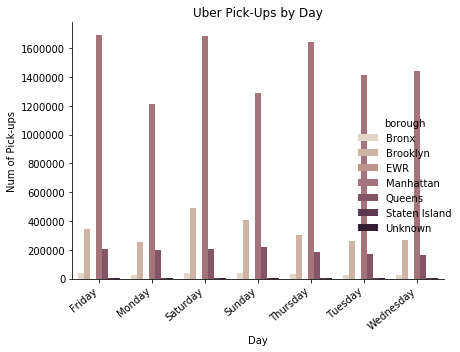

In [196]:
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               hue = "borough",
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day',
       xlabel='Day', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

In [198]:
stmt = (select([Uber.hour,Uber.borough, 
               func.count(Uber.hour).label('cnt')])
        .group_by(Uber.borough, Uber.hour))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts.head()

,hour,borough,cnt
0,0,Bronx,8923
1,1,Bronx,6446
2,2,Bronx,4811
3,3,Bronx,3969
4,4,Bronx,3731


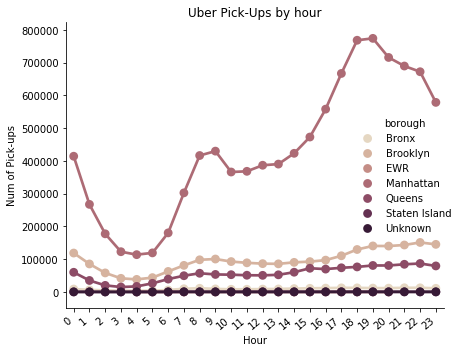

In [200]:
ax = (sns
      .catplot(x="hour", 
               y = 'cnt',
               kind="point", 
               hue = "borough",
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by hour',
       xlabel='Hour', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

In [201]:
stmt = (select([Uber.weekday,Uber.borough, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.borough, Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts.head()

,weekday,borough,cnt
0,Friday,Bronx,35557
1,Monday,Bronx,25799
2,Saturday,Bronx,41122
3,Sunday,Bronx,35114
4,Thursday,Bronx,29276


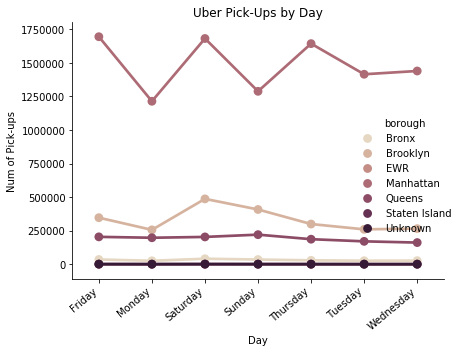

In [202]:
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="point", 
               hue = "borough",
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day',
       xlabel='Day', 
       ylabel='Num of Pick-ups')
plt.tight_layout()